In [27]:
import pandas as pd
from causalinference import CausalModel
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
data_path = './data/Fichier Wake-Up v01..xlsx'


## Covariates

In [29]:
# Leaving out "MedHistSmoking" as highly unbalanced, and as to many covars for samples
covar_fields = ['Age_(calc.)', 'Sex', 'Prestroke_disability_(Rankin)', 'Discovery_to_groin', 'NIH_on_admission',
                'MedHist_Hypertension', 'MedHist_Diabetes', 'MedHist_Hyperlipidemia',
                'MedHist_Atrial_Fibr.', 'wake_up', 'T6', 'CBF']


## Outcome variables:
any_bleeding	3M_Death	MRS01

In [30]:
outcome_var = 'any_bleeding'

## Intervention : IVT with rTPA

In [31]:
intervention_var = 'IVT_with_rtPA'

In [32]:

data = pd.read_excel(data_path)

data.columns = data.columns.str.replace(' ','_')

# Encode mRS (0 or 1) vs (> 1)
data['MRS01'] = data['3M_mRS'].isin([0, 1])

# Encode wake-up
data['wake_up'] = data['Time_of_symptom_onset_known'] == "wake up"

# Retain only relevant variables
data = data[covar_fields + [outcome_var, intervention_var]]



In [33]:
# Drop NaN (has to be done before one-hot-encoding)
data = data.dropna()

In [34]:

# One-hot encoding for categorical vars
data['Sex'] = data['Sex'] == 'Male'
data['MedHist_Hypertension'] = data['MedHist_Hypertension'] == 'yes'
data['MedHist_Diabetes'] = data['MedHist_Diabetes'] == 'yes'
data['MedHist_Hyperlipidemia'] = data['MedHist_Hyperlipidemia'] == 'yes'
data['MedHist_Atrial_Fibr.'] = data['MedHist_Atrial_Fibr.'] == 'yes'

data['IVT_with_rtPA'] = data['IVT_with_rtPA'] == 'yes'

if outcome_var != 'MRS01':
    data[outcome_var] = data[outcome_var] == 'yes'


data = data.astype(float)


Defining model with regards to IVT as intervention

In [35]:
intervention = data.IVT_with_rtPA.to_numpy()
outcome = data[outcome_var].to_numpy()

covars = data[covar_fields].to_numpy()

In [36]:
causal = CausalModel(outcome, intervention, covars)
print(causal.summary_stats)


Summary Statistics

                        Controls (N_c=17)          Treated (N_t=15)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.059        0.243        0.133        0.352        0.075

                        Controls (N_c=17)          Treated (N_t=15)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       66.965       20.275       70.809       14.201        0.220
             X1        0.529        0.514        0.533        0.516        0.008
             X2        0.235        0.562        0.867        1.246        0.653
             X3      197.588       51.044      249.467      108.283        0.613
             X4       17.235        6.350       14.400        6.345       -0.447
      

Estimate propensity scores

In [37]:
causal.est_propensity()
print(causal.propensity)
print(causal.propensity.keys())


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -18.095     11.237     -1.610      0.107    -40.121      3.930
            X0     -0.006      0.085     -0.068      0.946     -0.172      0.161
            X1      2.389      2.484      0.962      0.336     -2.479      7.257
            X2      4.442      2.954      1.504      0.133     -1.349     10.232
            X3      0.056      0.036      1.574      0.115     -0.014      0.126
            X4     -0.091      0.242     -0.376      0.707     -0.566      0.384
            X5     -0.889      2.424     -0.367      0.714     -5.639      3.862
            X6     -9.195      7.628     -1.205      0.228    -24.145      5.755
            X7     -1.406      3.040     -0.462      0.644     -7.364      4.553
            X8     -0.184      2.874     -0.064      0.949     -5.

Match by propensity scores (nearest-neighbour)

In [38]:
causal.est_via_matching(bias_adj=True)
print(f'Outcome variable: {outcome_var}')
print(causal.estimates)

Outcome variable: any_bleeding

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.133      0.200      0.665      0.506     -0.260      0.526
           ATC      0.133      0.205      0.650      0.516     -0.269      0.535
           ATT      0.133      0.238      0.559      0.576     -0.334      0.601



/Users/jk1/opt/anaconda3/envs/uw_bridging/lib/python3.8/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [39]:
data['propensity_score'] = causal.propensity['fitted']

## Distribution of covariates with respect to treatment and outcome

[]

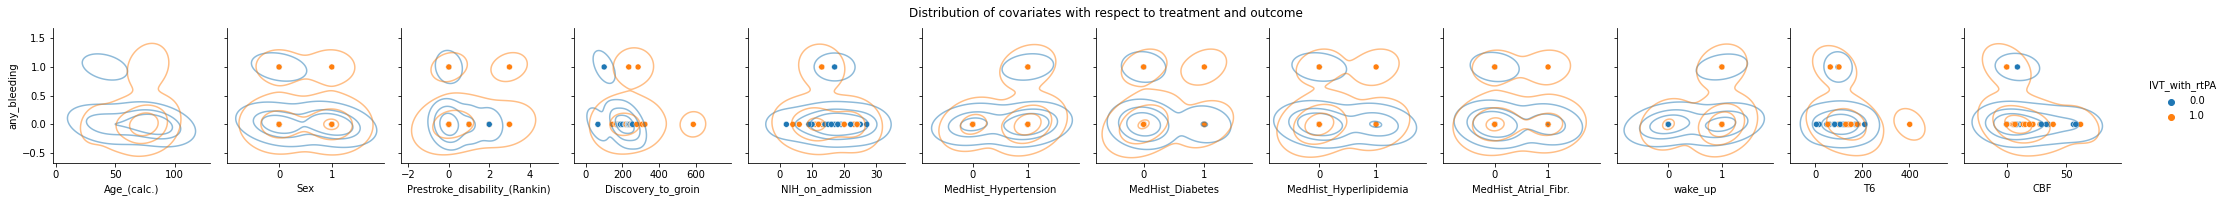

In [40]:
g = sns.pairplot(
    data,
    x_vars=covar_fields,
    y_vars=[outcome_var],
    hue=intervention_var,
    kind='scatter',
)
g.map(sns.kdeplot, alpha=.5, levels=4)

g.fig.suptitle('Distribution of covariates with respect to treatment and outcome', y=1.08)

plt.plot()

In [41]:
# sns.stripplot(x=outcome_var, y="propensity_score", hue='IVT_with_rtPA', data=data)
#

In [42]:
# sns.stripplot(x="index", y="propensity_score", hue='IVT_with_rtPA', data=data.reset_index())

